# Experiment with Divorce Predictor Dataset.

## Module Imports

In [1]:
import sys
import os
l = os.getcwd().split('/')[:-1]
l.append('pyproclus')
sys.path.insert(0,'/'.join(l))
import proclus as prc
import plotter
import arffreader as ar
import numpy as np
import adjrand
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots

## Data Loading and pre-processing

In [2]:
data = pd.read_csv('divorce.csv', ';')
data.shape

(170, 55)

In [3]:
X, Y = data.iloc[:,:-1], data.iloc[:, -1]

In [4]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

/home/animeshdeb30/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.



## Applying TSNE

In [5]:
tsne = TSNE(n_components=2, perplexity = 12, 
            n_iter=1000, method = 'barnes_hut')

tsne_result = tsne.fit_transform(X_minmax)

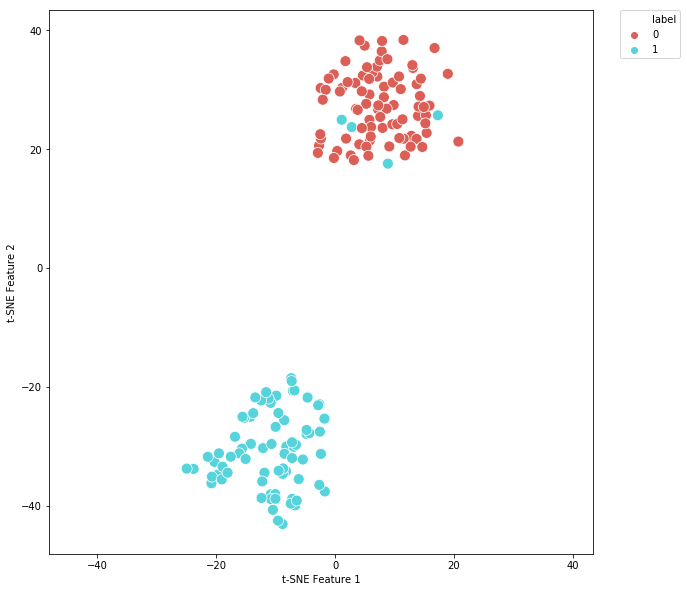

In [6]:
tsne_result_df = pd.DataFrame({'t-SNE Feature 1': tsne_result[:,0], 't-SNE Feature 2': tsne_result[:,1], 
                               'label': Y})
fig, ax = plt.subplots(figsize=(13,10))
sns.scatterplot(x='t-SNE Feature 1', y='t-SNE Feature 2', hue='label', data=tsne_result_df, 
                ax=ax,s=120, palette = sns.color_palette("hls", 2))
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Testing for TSNE 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(tsne_result, Y, test_size=0.25, random_state=0)

In [8]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

### Accuracy 

In [9]:
print(accuracy_score(y_test, y_pred))

0.9534883720930233


### F-1 score
#### For Divorced

In [10]:
print(f1_score(y_test, y_pred))

0.9500000000000001


#### For Married

In [11]:
y_test_M = np.where(y_test == 0, 1, 0)
y_pred_M = np.where(y_pred == 0, 1, 0)
print(f1_score(y_test_M, y_pred_M))

0.9565217391304348


### Precision
#### For Divorced

In [12]:
print(precision_score(y_test, y_pred))

1.0


#### For Married

In [13]:
print(precision_score(y_test_M, y_pred_M))

0.9166666666666666


### Recall
#### For Divorced

In [14]:
print(recall_score(y_test, y_pred))

0.9047619047619048


#### For Married

In [15]:
print(recall_score(y_test_M, y_pred_M))

1.0


## Aplying Subspace Clustering

In [16]:
Y = Y.astype('int64').to_numpy()

In [17]:
R = 1 # toggle run proclus
RS = 0 # toggle use random seed
if R: 
    rseed = 1010954
    if RS:
        rseed = np.random.randint(low = 0, high = 1239831)
    print "Using seed %d" % rseed
    M, D, A = prc.proclus(X_minmax, k = 4, l = 5, seed = rseed, A = 10, B = 5)
    print "Accuracy: %.4f" % prc.computeBasicAccuracy(A, Y)
    adj = adjrand.computeAdjustedRandIndex(A, Y)
    print "Adjusted rand index: %.4f" % adj
    #plotter.plotClustering(x_plot, M, A, D = Dims)

Using seed 1010954
bad medoids:
[126]
old mcurr:
[124  10   8 126]
new mcurr:
[  8  10 124 132]
finished iter: 1
finished iter: 2
finished iterative phase...
Accuracy: 0.9647
Adjusted rand index: 0.6398


### Comparing Result in TSNE embeddings.

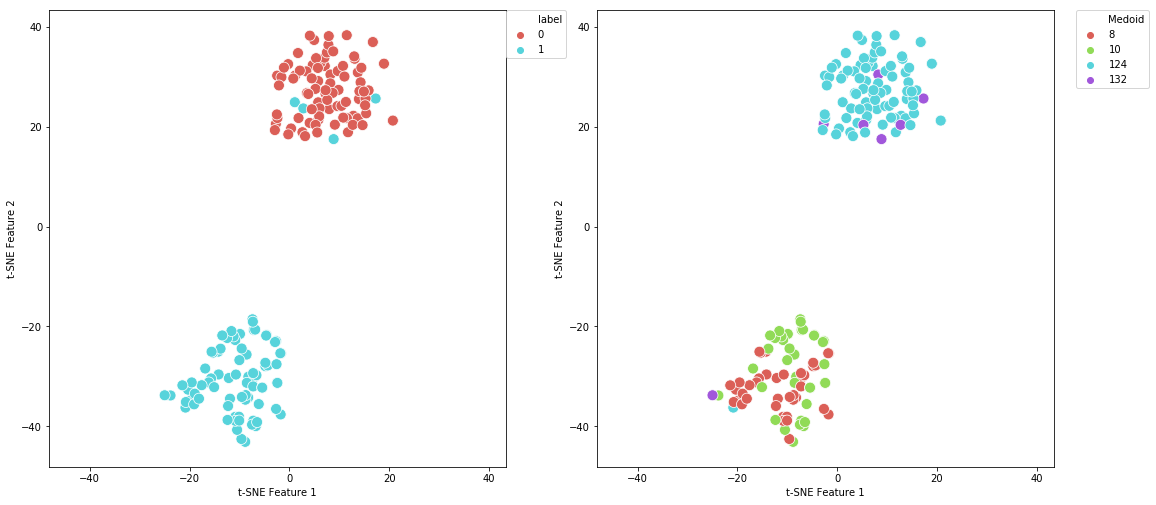

In [18]:
tsne_result_df = pd.DataFrame({'t-SNE Feature 1': tsne_result[:,0], 't-SNE Feature 2': tsne_result[:,1], 
                               'label': Y})
tsne_result_SC = pd.DataFrame({'t-SNE Feature 1': tsne_result[:,0], 't-SNE Feature 2': tsne_result[:,1], 
                               'Medoid': A.astype(int)})


fig, ax = plt.subplots(1, 2, figsize=(18,10))


sns.scatterplot(x='t-SNE Feature 1', y='t-SNE Feature 2', hue='label', data=tsne_result_df, 
                ax=ax[0],s=120, palette = sns.color_palette("hls", 2))
ax[0].lim = (tsne_result.min()-5, tsne_result.max()+5)
ax[0].set_xlim(lim)
ax[0].set_ylim(lim)
ax[0].set_aspect('equal')
ax[0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)


sns.scatterplot(x='t-SNE Feature 1', y='t-SNE Feature 2', hue='Medoid', data=tsne_result_SC, 
                ax=ax[1],s=120, palette = sns.color_palette("hls", 4))
ax[1].lim = (tsne_result.min()-5, tsne_result.max()+5)
ax[1].set_xlim(lim)
ax[1].set_ylim(lim)
ax[1].set_aspect('equal')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Comparing Results in Parallel Coordinate Plots.

In [19]:
M

array([  8,  10, 124, 132])

In [20]:
D

[[16, 18, 12, 10, 14, 6, 8],
 [36, 38, 40, 49, 48, 51, 39, 32, 53],
 [35, 6],
 [26, 22]]

In [33]:
cluster_1 = 1
cluster_2 = 2

In [34]:
x_minmax = pd.DataFrame(min_max_scaler.inverse_transform(X_minmax), columns = X.columns)

In [35]:
columns_i = list(set(D[cluster_1]).union(set(D[cluster_2])))
x_i = x_minmax.iloc[:, columns_i]
x_i['y'] = np.zeros((x_i.shape[0], 1), dtype = int)
x_i.iloc[np.where(A == M[cluster_1])[0],-1] = 1
x_i.iloc[np.where(A == M[cluster_2])[0],-1] = 2
data = x_i[x_i['y']!=0]
data.reset_index(inplace = True, drop = True)

/home/animeshdeb30/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [36]:
fig = px.parallel_coordinates(data, color="y",
                              color_continuous_scale=px.colors.sequential.Plasma,
                              color_continuous_midpoint=2)
fig.show()

### Testing for Subspace Clustering

In [25]:
Y_clus = np.zeros(Y.shape)
Y_clus = np.where(A <= 10, 1, 0)

### Accuracy 

In [26]:
print(accuracy_score(Y, Y_clus))

0.9647058823529412


### F-1 score
#### For Divorced

In [27]:
print(f1_score(Y, Y_clus))

0.962962962962963


#### For Married

In [28]:
y_M = np.where(Y == 0, 1, 0)
y_clus_M = np.where(Y_clus == 0, 1, 0)
print(f1_score(y_M, y_clus_M))

0.9662921348314606


### Precision
#### For Divorced

In [29]:
print(precision_score(Y, Y_clus))

1.0


#### For Married

In [30]:
print(precision_score(y_M, y_clus_M))

0.9347826086956522


### Recall
#### For Divorced

In [31]:
print(recall_score(Y, Y_clus))

0.9285714285714286


#### For Married

In [32]:
print(recall_score(y_M, y_clus_M))

1.0


# Thank you.